# Test Task

# Analyze the organization name recognition system and dataset annotations



### The Road Ahead

Here, break the notebook into separate steps.

* [Step 1](#step1): Load Enron Dataset
* [Step 2](#step2): Analyze spacy model performace on Enron file
* [Step 3](#step3): Load OntoNotes Dataset
* [Step 4](#step4): Analyze spacy model performace on OntoSentences file

---
<a id='step1'></a>
## Step 1: Load Enron Dataset

### 1.1 Load Enron Dataset
Open and load EnronSentences.json file
The type of the data is list and length = 310

In [1]:
import json

# Open JSON file
with open('EnronSentences.json') as json_file:
    Enron_data = json.load(json_file)
    
    print(type(Enron_data))
    print(len(Enron_data))

<class 'list'>
310


### 1.2 Take the first email as an example.
#### Email is read in dict. 

In [2]:
# print an email and check content
print(Enron_data[0])
print("Enron_data[0] type:",type(Enron_data[0]))

{'text': 'Shelley: Do you have any information on Project Max that we could use in the business plan for NNG?', 'machine_entities': [[95, 98, 'ORG', 'machine']], 'human_entities': {}}
Enron_data[0] type: <class 'dict'>


#### Check keys and its value.

In [3]:
# check each dictionary keys and value
print(Enron_data[0].keys())
input_text = Enron_data[0]['text']
output = Enron_data[0]['machine_entities']
print(input_text)
print(type(output), " ", output)
print(output[0][:3])
print(output[0][-1])

dict_keys(['text', 'machine_entities', 'human_entities'])
Shelley: Do you have any information on Project Max that we could use in the business plan for NNG?
<class 'list'>   [[95, 98, 'ORG', 'machine']]
[95, 98, 'ORG']
machine


### 1.3 Import spacy and analyze the first email.

In [4]:
import spacy

nlp = spacy.load("en_core_web_sm")    

In [5]:
doc = nlp(input_text)
output_spacy = []
for ent in doc.ents:
    if ent.label_ == "ORG":
        output_spacy.append([ent.start_char,ent.end_char,ent.label_])
print(output_spacy)

[[95, 98, 'ORG']]


#### Compare the value got from spacy and file

In [6]:
result = output[0][:3] == output_spacy[0]
print(result)

True


<a id='step2'></a>
## Step 2: Analyze spacy model performace on Enron file


In [7]:
def read_each_email(n):
    """
    Read each email and return:
        - email content(input_text)
        - email annotated output(output)
        - number of annotated named(len_output)
    """
    input_text = Enron_data[n]['text']
    output_machine = Enron_data[n]['machine_entities']
    len_machine = len(output_machine)
    len_output = 0
    output = []
    
    if Enron_data[n]['human_entities'] != {}:

        output_human_dict = Enron_data[n]['human_entities']
        output = list(output_human_dict.values())[0]
        
        len_human = len(output)
    else:
        output = output_machine
        len_output = len_machine
    
    return input_text, output, len_output


In [8]:
def get_predict_from_spacy(input_text):
    """
    Spacy is used to annotate ORG name from email content
    Return annotated result
    """
    doc = nlp(input_text)
    output_spacy = []
    for ent in doc.ents:
        if ent.label_ == "ORG":
            output_spacy.append([ent.start_char,ent.end_char,ent.label_])
    
    return output_spacy

In [9]:
def complete_match(output, predict):
    """
    Check weather Spacy's predict has the same result of target
    output - Enron result
    predict - Spacy's predict
    """
    if predict == output:
        return 1
    else:
        return 0

def correct_find(output, predict):
    """
    find whether the names annotated by spacy are in the range of target
    output - Enron result
    predict - Spacy's predict
    
    The name annotated by spacy sometime starts or ends with different position from target.
    However, sometimes, a part of the name is annotated by spacy.
    This situation is considered as spacy found name correctly.
    """
    find_name = 0
    for value_predict in predict:
        for value_output in output:
            if value_predict[0] > value_output[1] or value_predict[1] < value_output[0]:
                find_name += 0
            else:
                find_name += 1
    return find_name


In [10]:
import pandas as pd
import re
from string import punctuation

id_list = []
length_list = []
uppercase_num_list = []
punctuation_num_list = []
digital_num_list = []
result_list = []

def save_to_csv(file_name):
    """
    save email features to a csv file
    """
    
    df = pd.DataFrame(list(zip(id_list, length_list, uppercase_num_list, punctuation_num_list, digital_num_list, result_list)), 
               columns =['ID', 'sentence_length', 'uppercase_number', 'punctuation_number', 'digital_number', 'result']) 
    df.to_csv(file_name, index=False)

def record_feature_and_result(i, input_text, result):
    """
    collect features and result of an email
    """
    
    id_list.append(i)
    
    sentence_len = len(input_text)
    length_list.append(sentence_len)
    
    uppercase_num = len(re.findall(r'[A-Z]', input_text))
    uppercase_num_list.append(uppercase_num)
    
    punctuation_num = sum([1 for c in input_text if c in punctuation])
    punctuation_num_list.append(punctuation_num)
    
    digital_num = len(re.sub("[^0-9]", "", input_text))
    digital_num_list.append(digital_num)
    
    result_list.append(result)    

### 2.1 Use spacy to analyze all emails in Enron file

For each email in Enron, compare spacy output and Enron target result

In [11]:
complete_correct_number = 0
position_find_number = 0
false_positive_number = 0
false_negative_number = 0
ture_negative_number = 0
result = 0 

for i in range(len(Enron_data)):
    input_text, output_Enron, len_output = read_each_email(i)
    output_spacy = get_predict_from_spacy(input_text)
    len_spacy = len(output_spacy)
    
    output_corrected_by_human = []
    
    for n in range(len_output):
        if output_Enron[n][2] != '':
            output_corrected_by_human.append(output_Enron[n][:3])
    
    if complete_match(output_corrected_by_human, output_spacy) == 1:
        result = 1
        if output_spacy == []:
            ture_negative_number += 1
        else:
            complete_correct_number += 1
        #print(i, " Completely Match enron human: ", output_corrected_by_human, " spacy: ", output_spacy)
        
    elif correct_find(output_corrected_by_human, output_spacy) == len(output_corrected_by_human):
        result = 1
        position_find_number += 1
        #print(i, " Position Match enron human: ", output_corrected_by_human, " spacy: ", output_spacy)

    else:
        result = 0
        if len_spacy >= len_output:  # spacy has false positive
            false_positive_number += 1

        elif len_spacy < len_output:  # spacy has false negative
            false_negative_number += 1
            #print(input_text)
            #print(i, " enron human: ", output_corrected_by_human, " spacy: ", output_spacy)

    record_feature_and_result(i, input_text, result)

save_to_csv('EnronSentence_feature.csv')

print("complete_correct_number Positive: ", complete_correct_number)
print("All position found: ", position_find_number)
print("True Positive: ", complete_correct_number + position_find_number)
print("True Negative: ", ture_negative_number)
print("with false positive number: ", false_positive_number)
print("with false negative number: ", false_negative_number)

complete_correct_number Positive:  73
All position found:  115
True Positive:  188
True Negative:  26
with false positive number:  13
with false negative number:  83


Here use the following matrix to analyze results

|               |Predict Positive        | Predict Negative           |
| ------------- |:-------------:| -----:|
| Positive      | True Positive | False Negative |
| Negative      | False Positive| True Negative  |

Based on the result from above step, it is easy to find: 
- there are 73 emails correctly annotate ORG by spacy
- there are 115 emaild can include then names needed to be annotated by spacy
- there are 26 emails don't have ORG name checked by spacy, the same as Enton file
- there are 2 emails annotated with wrong ORG name by spacy
- there are 83 emails which can not be annotated ORG name by spacy
- hence,
        True Positive = 73 + 115 = 188
        True Negative = 26
        False Positive = 13
        False Negative = 83

When only consider correct results, then:
- Accuracy = (True Positive + True Negative)/ Total = (188 + 26) / 310 = 0.69
- Recall = True Positive/(True Positive + False Negative) = 188/(188+83) = 0.69



### 2.2 Compare features of email
Use collected email features: 
    - email length, 
    - uppercase word number, 
    - punctuation number, 
    - digital number
to compare emails successfully annotated by spacy and emails can not be annotated.

[Text(0, 0.5, 'Result'), Text(0.5, 0, 'Digital Number')]

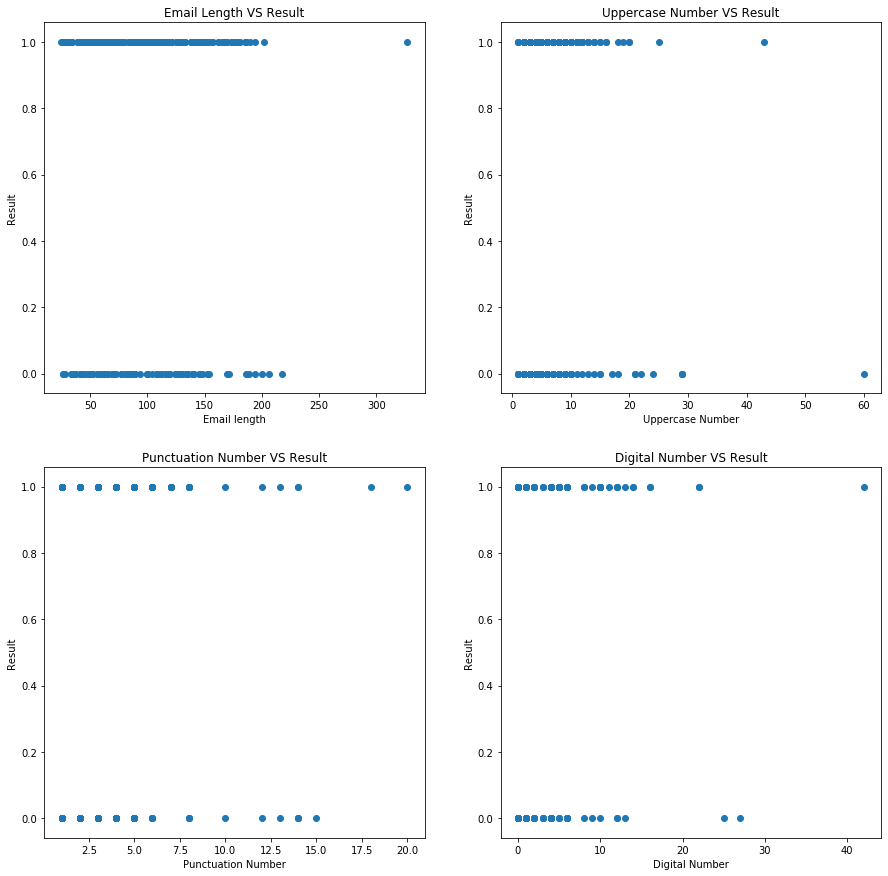

In [13]:
import matplotlib.pyplot as plt
"""
length_list
uppercase_num_list
punctuation_num_list
digital_num_list
result_list
"""

x1 = length_list
x2 = uppercase_num_list
x3 = punctuation_num_list
x4 = digital_num_list
y = result_list

fig, axs = plt.subplots(2, 2, figsize=(15,15))
axs[0,0].scatter(x1, y, marker='o')
axs[0,0].set_title('Email Length VS Result')
axs[0,0].set(xlabel='Email length', ylabel='Result')

axs[0,1].scatter(x2, y, marker='o')
axs[0,1].set_title('Uppercase Number VS Result')
axs[0,1].set(xlabel='Uppercase Number', ylabel='Result')

axs[1,0].scatter(x3, y, marker='o')
axs[1,0].set_title('Punctuation Number VS Result')
axs[1,0].set(xlabel='Punctuation Number', ylabel='Result')

axs[1,1].scatter(x4, y, marker='o')
axs[1,1].set_title('Digital Number VS Result')
axs[1,1].set(xlabel='Digital Number', ylabel='Result')

### Feature analysis

Based on the four figures listed above, found that it is difficult to admit these feature would effact spacy analysis.

#### Email length
There is no big difference for spacy analysis when email length shorter than 150.
When email length is longer than 150, spacy has a liiter higher accuracy.

#### Uppercase word number, Punctuation number, Digital number
From the plotted figure, it is hard to say Spacy would be effected by these three reasons.

### 2.3 Move to ORG Name Analysis

In the next session, collect words that spacy successfully annotated, and words that spacy failed to annotate.

In [14]:
name_true_pos_num = 0
name_true_neg_num = 0
name_false_pos_num = 0
name_false_neg_num = 0

name_found = []
name_missed = []

def find_word(value, text):
    """
    According to the start and end position to find the ORG name
    """
    if value != []:
        start = value[0]
        end = value[1]
        word = text[start:end]
        return word
    else:
        pass

for i in range(len(Enron_data)):
    input_text, output_Enron, len_output = read_each_email(i)
    output_spacy = get_predict_from_spacy(input_text)
    len_spacy = len(output_spacy)
    
    output_corrected_by_human = []
    
    for n in range(len_output):
        if output_Enron[n][2] != '':
            output_corrected_by_human.append(output_Enron[n][:3])
    
    if output_spacy != [[]]:
        
        for m in range(len_spacy):
            if output_spacy[m] in output_corrected_by_human and output_spacy[m] != []:
                name = find_word(output_spacy[m], input_text)
                name_found.append(name)
            else:
                for value in output_corrected_by_human:
                    name = find_word(value, input_text)
                        
                    if output_spacy[m][0] < value[1] and output_spacy[m][1] > value[0]:
                        name_found.append(name)
                    else:
                        name_missed.append(name)
    else:
        if output_corrected_by_human != [[]]:
            for value in output_corrected_by_human:
                name = find_word(value, input_text)
                name_missed.append(name)

print("Names annotate by Spacy: \n")
print(name_found)
print("Totally found: ", len(name_found), " times\n")
print("Names can not be annotate by Spacy: \n")
print(name_missed)
print("Totally not found: ", len(name_missed), " times\n")

Names annotate by Spacy: 

['NNG', 'ENA', 'Sierra', 'Oxley', 'CEC', 'East', 'ICAP', 'Stinson/Vince', 'Enron', 'ENA', 'Trust', 'Ambac', "Moody's", 'AAA', 'Standard', 'Central', 'Enron', 'Global', 'Enron', 'PEPL', 'Texas', 'Christi', 'RAC', 'Eastern', 'HPL', 'Enron', 'MILLS', 'Supervisor', 'MILLS', 'SHRM', 'CRRA', 'Yahoo', 'FBI', 'CommodityLogic', 'Nicor', 'Nicor', 'The', 'Peoples', 'Enron', 'Enron', 'EOTT', 'Enron', 'Enron', 'EOTT', 'Associates', 'Enron', 'Morton', 'ENA', 'HSC', 'Cinergy', 'ENA', 'NDA', 'Enron', 'Enron', 'CSA', 'Harvard', 'Wal-Mart', 'Yahoo', 'SoCal', 'Corp.', 'Amazon.com', 'Amazon.com', 'DealBench', 'ProCaribe', 'LPG', 'ProCaribe', 'Bracewell', 'FYI', 'GPG', 'Reserve', 'GTC', 'Delphi', 'Enron', 'FYI', 'Enron', 'Travelocity.com', 'Socal', 'ECT', 'FYI', 'CI', 'Containerisation', 'Containerisation', 'Reuters', 'Shelley', 'Japanese', 'EES', 'Board', 'HPL', 'ENA', 'ENA', 'Central', 'Gallup', 'Dennis', 'CLEC', 'Zone', 'Canadian', 'Cordes', 'Lotus', 'DETM', 'Model', 'Groups',

In [15]:
from collections import Counter

counts_found = Counter(name_found)
print(counts_found)
vocab_found = sorted(counts_found, key=counts_found.get, reverse=True)

counts_missed = Counter(name_missed)
print(counts_missed)
vocab_missed = sorted(counts_missed, key=counts_missed.get, reverse=True)

Counter({'Enron': 17, 'ENA': 8, 'Nicor': 3, 'FYI': 3, 'VAR': 3, 'Sierra': 2, 'Central': 2, 'Texas': 2, 'HPL': 2, 'MILLS': 2, 'Yahoo': 2, 'The': 2, 'EOTT': 2, 'NDA': 2, 'Harvard': 2, 'Amazon.com': 2, 'ProCaribe': 2, 'Containerisation': 2, 'PG&E': 2, 'VMAC': 2, 'ISO': 2, 'CNN': 2, 'NNG': 1, 'Oxley': 1, 'CEC': 1, 'East': 1, 'ICAP': 1, 'Stinson/Vince': 1, 'Trust': 1, 'Ambac': 1, "Moody's": 1, 'AAA': 1, 'Standard': 1, 'Global': 1, 'PEPL': 1, 'Christi': 1, 'RAC': 1, 'Eastern': 1, 'Supervisor': 1, 'SHRM': 1, 'CRRA': 1, 'FBI': 1, 'CommodityLogic': 1, 'Peoples': 1, 'Associates': 1, 'Morton': 1, 'HSC': 1, 'Cinergy': 1, 'CSA': 1, 'Wal-Mart': 1, 'SoCal': 1, 'Corp.': 1, 'DealBench': 1, 'LPG': 1, 'Bracewell': 1, 'GPG': 1, 'Reserve': 1, 'GTC': 1, 'Delphi': 1, 'Travelocity.com': 1, 'Socal': 1, 'ECT': 1, 'CI': 1, 'Reuters': 1, 'Shelley': 1, 'Japanese': 1, 'EES': 1, 'Board': 1, 'Gallup': 1, 'Dennis': 1, 'CLEC': 1, 'Zone': 1, 'Canadian': 1, 'Cordes': 1, 'Lotus': 1, 'DETM': 1, 'Model': 1, 'Groups': 1, 'CF

### Compared Names

From the two word list, there are some words appeared in both list, like 'Enron', 'ENA', 'CEC', 'Central', 'Morton', 'EOT', 'PG&E'. Hence, next will consider the patterns of emails.

Hence, it is difficult to say the reason why spacy didn't annotate the ORG is the Name.

Then move to find other reason might cause the error. This needs to look into the email content.



### 2.4 Email Content or Structure/Pattern Analysis

The idea is that:
for the email which spacy failed to annotate ORG name, try to do little change making spacy work again.

If this idea would work, then we might figur out some reason.

In [16]:
# Generate the index list including all index id of emails which spacy failed to annotate

df = pd.read_csv('EnronSentence_feature.csv')
df_error = df[df['result']==0]
df_error
df_error['ID'].values

array([  2,   5,   6,   9,  13,  15,  16,  17,  18,  21,  23,  32,  36,
        38,  41,  42,  48,  55,  60,  67,  73,  78,  80,  83,  85,  89,
        91,  93,  97, 100, 103, 107, 109, 111, 112, 114, 115, 122, 124,
       130, 136, 142, 143, 144, 149, 155, 160, 161, 163, 164, 167, 171,
       180, 182, 185, 186, 190, 192, 193, 195, 200, 203, 204, 205, 206,
       208, 211, 212, 219, 223, 225, 226, 229, 232, 234, 235, 237, 239,
       241, 247, 251, 254, 255, 257, 258, 261, 264, 265, 267, 270, 275,
       276, 282, 284, 288, 289])

In [17]:
# Here, just take 10 emails as example to analyze

for n in range(10):
    index = df_error['ID'].values[n]
    text, output, len_output = read_each_email(index)
    name = []
    for value in output:
        name.append(text[value[0]:value[1]])
    print(text)
    print("Position: ", output, "  ORG Name: ", name)
    print("=======================")

Mary, Jason Orta from the CEC called me to inform us that one of the generator numbers we had used was wrong.
Position:  [[26, 29, 'ORG', 'machine']]   ORG Name:  ['CEC']
Steve Harris and the Transwestern Commercial Team would like to extend an invitation to our Christmas Luncheon on Wednesday, December 13, 11:30 a.m. at the Rodizio Restaurant on Westheimer and Chimney Rock.
Position:  [[178, 188, 'ORG', 'machine']]   ORG Name:  ['Westheimer']
What does the Gingerbread Boy have on his bed?
Position:  [[14, 25, 'ORG', 'machine']]   ORG Name:  ['Gingerbread']
I would like to set up a GISB agreement to trade with Sempra.
Position:  [[25, 29, 'ORG', 'machine']]   ORG Name:  ['GISB']
NOTE: Circulation of the "Electricity Daily Demand Forecast" outside a Client's licensed distribution area is strictly prohibited.
Position:  [[71, 77, 'ORG', 'machine']]   ORG Name:  ['Client']
Please advise if ENA is ok to reference in the Confirmation.
Position:  [[17, 20, 'ORG', 'machine'], [47, 59, 'ORG', 

#### Take the first email to analysis

In [18]:
# For the first email, spacy failed to get ORG name CEC from the original email 

input_text_orig1 = "Mary, Jason Orta from the CEC called me to inform us that one of the generator numbers we had used was wrong."
output_spacy1 = get_predict_from_spacy(input_text_orig1)
print("The result of original email: ", output_spacy1)

# Then through several tries, found:
# when change "me" to "us" or delete "me", then spacy can annotate ORG name correctly

input_text_chg1 = "Mary, Jason Orta from the CEC called us to inform us that one of the generator numbers we had used was wrong."
output1 = get_predict_from_spacy(input_text_chg1)
print("The result of first changed email: ", output1)

input_text_chg2 = "Mary, Jason Orta from the CEC called to inform us that one of the generator numbers we had used was wrong."
output2 = get_predict_from_spacy(input_text_chg2)
print("The result of first changed email: ", output2)

The result of original email:  []
The result of first changed email:  [[26, 29, 'ORG']]
The result of first changed email:  [[26, 29, 'ORG']]


In [19]:
# Based on the above analysis, then spacy might related to singular and plural pattern
# And then take the 4th emails from the printed list
input_text_orig4 = "I would like to set up a GISB agreement to trade with Sempra."
output_spacy4 = get_predict_from_spacy(input_text_orig4)
print("The result of original email: ", output_spacy4)

# If spacy might related to singular and plural pattern, then "a" in the content might effect result.
# Do the change: remove "a"
input_text_chg = "I would like to set up GISB agreement to trade with Sempra."
output1 = get_predict_from_spacy(input_text_chg)
print("The result of first changed email: ", output1)

The result of original email:  []
The result of first changed email:  [[23, 27, 'ORG']]


####  check the second email

In [20]:
input_text_orig2 = "Steve Harris and the Transwestern Commercial Team would like to extend an invitation to our Christmas Luncheon on Wednesday, December 13, 11:30 a.m. at the Rodizio Restaurant on Westheimer and Chimney Rock."
output_spacy2 = get_predict_from_spacy(input_text_orig2)
print("The result of original email: ", output_spacy2)

# Do the change: remove "on", then find "Westheimer"
input_text_chg = "Steve Harris and the Transwestern Commercial Team would like to extend an invitation to our Christmas Luncheon on Wednesday, December 13, 11:30 a.m. at the Rodizio Restaurant Westheimer and Chimney Rock."
output1 = get_predict_from_spacy(input_text_chg)
print("The result of first changed email: ", output1)

# However, here, "Westheimer" is location name not ORG. This is an error in Enron. 

The result of original email:  [[17, 49, 'ORG'], [102, 110, 'ORG']]
The result of first changed email:  [[17, 49, 'ORG'], [102, 110, 'ORG'], [152, 185, 'ORG']]


#### Check the 7th email

Enron file take people name as ORG name is a mistake. Another error is missed "Frontera" as ORG name.
Spacy is good to annotate "Frontera" as ORG and avoid people name "Ken". However, when change "Ken" to all uppercase word "KEN", spacy annotate it as ORG name.

In [21]:
# People name "Ken" in the 7th email
input_text_orig7 = "Steve indicated below that he talked to Ken at Frontera."
output_spacy7 = get_predict_from_spacy(input_text_orig7)
print("The result of original email: ", output_spacy7)

# When change "Ken" to uppercase "KEN"
input_text_chg = "Steve indicated below that he talked to KEN at Frontera."
output = get_predict_from_spacy(input_text_chg)
print("The result of first changed email: ", output)

The result of original email:  [[47, 55, 'ORG']]
The result of first changed email:  [[40, 43, 'ORG'], [47, 55, 'ORG']]


#### Check the 9th email

Because the 8th email has error and missed the ORG name NASDAQ-100, and the 9th email has the same name, then just check the 9th email. 

In [22]:
input_text_orig9 = "At maturity, the Trust is scheduled to repay the entire principal amount of the certificates, plus an amount based on the return of the Nasdaq-100 Index subject to a quarterly appreciation cap of 12%."
output_spacy9 = get_predict_from_spacy(input_text_orig9)
print("The result of original email: ", output_spacy9)

# When change "Nasdaq-100" to "Nasdaq", it can be annotated by spacy
input_text_chg = "At maturity, the Trust is scheduled to repay the entire principal amount of the certificates, plus an amount based on the return of the Nasdaq Index subject to a quarterly appreciation cap of 12%."
output = get_predict_from_spacy(input_text_chg)
print("The result of first changed email: ", output)

# The punctuation and digital number might effect the judgement of spacy

The result of original email:  [[17, 22, 'ORG']]
The result of first changed email:  [[17, 22, 'ORG'], [136, 142, 'ORG']]


#### Check the 10th email

In [23]:
input_text_orig10 = "Enerfax GOLD NORTH AMERICA'S FREE?"
output_spacy10 = get_predict_from_spacy(input_text_orig9)
print("The result of original email: ", output_spacy9)

# "Enerfax" might not in spacy ORG dictionary. 
# When it changed to a name with higher frequency found, "ENA", spacy can annotate it.
input_text_chg = "ENA GOLD NORTH AMERICA'S FREE?"
output = get_predict_from_spacy(input_text_chg)
print("The result of first changed email: ", output)

The result of original email:  [[17, 22, 'ORG']]
The result of first changed email:  [[0, 24, 'ORG']]


<a id='step3'></a>
## Step 3: Load OntoNotes Dataset

### Load OntoNotes.json file

In [24]:
# Open JSON file
with open('OntoNotes.json') as json_file:
    Onto_data = json.load(json_file)
    
    print(type(Onto_data))
    print(len(Onto_data))

<class 'list'>
5000


In [25]:
print(Onto_data[0])
print("Onto_data[0] type:",type(Onto_data[0]))
print(Onto_data[0][0])
output_Onto = Onto_data[0][1]['entities']
print(output_Onto)

output_test = []
for value in output_Onto:
    if value[2] == 'ORG':
        output_test.append(value)
output_test

['The head of the Palestinian Television and Radio has been shot dead in the Gaza Strip .', {'entities': [[12, 48, 'ORG'], [71, 85, 'GPE']]}]
Onto_data[0] type: <class 'list'>
The head of the Palestinian Television and Radio has been shot dead in the Gaza Strip .
[[12, 48, 'ORG'], [71, 85, 'GPE']]


[[12, 48, 'ORG']]

In [26]:
input_text = str(Onto_data[0][0])
print(input_text)
output_spacy = get_predict_from_spacy(input_text)
print(output_spacy)

The head of the Palestinian Television and Radio has been shot dead in the Gaza Strip .
[[12, 38, 'ORG'], [43, 48, 'ORG']]


<a id='step4'></a>
## Step 4: Analyze spacy model performace on OntoSentences file

In [27]:
def read_output_from_OntoNotes(n):
    info = Onto_data[n]
    input_text = str(Onto_data[n][0])
    output = Onto_data[n][1]['entities']
    output_Onto = []
    for value in output:
        if value[2] == 'ORG':
            output_Onto.append(value)
    
    return input_text, output_Onto

In [28]:
complete_correct_number = 0
position_find_number = 0
false_positive_number = 0
false_negative_number = 0
ture_negative_number = 0

for n in range(len(Onto_data)):
    input_text, output_Onto = read_output_from_OntoNotes(n)
    len_output = len(output_Onto)
    output_spacy = get_predict_from_spacy(input_text)
    len_spacy = len(output_spacy)
    
    if complete_match(output_Onto, output_spacy) == 1:

        if output_spacy == []:
            ture_negative_number += 1
        else:
            complete_correct_number += 1
        #print(i, " Completely Match OntoSentences: ", output_Onto, " spacy: ", output_spacy)
    elif correct_find(output_Onto, output_spacy) == len(output_Onto):
        position_find_number += 1     
    
    else:
        if len_spacy >= len_output:  # spacy has false positive
            false_positive_number += 1
        
        elif len_spacy < len_output:  # spacy has false negative
            false_negative_number += 1
            #print(input_text)
            #print(n, " OntoSentences: ", output_Onto, " spacy: ", output_spacy)
                
print("complete_correct_number Positive: ", complete_correct_number)
print("All position found: ", position_find_number)
print("True Positive: ", complete_correct_number + position_find_number)
print("True Negative: ", ture_negative_number)
print("with false positive number: ", false_positive_number)
print("with false negative number: ", false_negative_number)


complete_correct_number Positive:  1397
All position found:  190
True Positive:  1587
True Negative:  3341
with false positive number:  11
with false negative number:  61


Based on the result from above step, it is easy to find:

there are 1397 emails correctly annotate ORG by spacy
there are 190 emaild can include then names needed to be annotated by spacy
there are 3341 emails don't have ORG name checked by spacy, the same as Enton file
there are 11 emails annotated with wrong ORG name by spacy
there are 61 emails which can not be annotated ORG name by spacy
hence,
  True Positive = 1397 + 190 = 1587
  True Negative = 3341
  False Positive = 11
  False Negative = 61
When only consider correct results, then:

Accuracy = (True Positive + True Negative)/ Total = (1587 + 3341) / 5000 = 0.99
Recall = True Positive/(True Positive + False Negative) = 1587/(1587+61) = 0.96
